# Вторая лабораторная работа
## Регрессионный анализ
## Цель задания
Изучить основы регрессионного анализа в машинном обучении, освоить
практические навыки построения и оценки регрессионных моделей для
решения задач прогнозирования непрерывных величин.

## Выполнение

### 1. Выбор датасета
Для лабораторной работы №2 нужен датасет подходящий для предсказания непрерывных значений. Такой датасет должен удовлетворять следующим критериям: \
    1) Целевая переменная — числовая и непрерывная \
    2) Достаточная вариативность и покрытие диапазона \
    3) Остаточный объём выборки \
    4) Независимость/корреляции наблюдений (IID) 
    
https://www.kaggle.com/datasets/nabeelqureshitiii/student-performance-dataset


## 2. Предобработка данных

### Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso


### Анализ пропущенных значение и их обработка

In [2]:
dataset = pd.read_csv("./data/student_performance.csv")

def process_null_val():
    null_val_count = dataset.isnull().sum()

    print("Количество пропусков")
    print(null_val_count)

    if len(null_val_count) > 0:
        return dataset.dropna()
    else:
        return dataset


def process_duplicate_rows():
    duplicate_row_count = dataset.duplicated().sum()

    print(f"Количество дубликатов: {duplicate_row_count}")

    if duplicate_row_count > 0:
        return dataset.drop_duplicates()
    else:
        return dataset
    
process_null_val()
process_duplicate_rows()

Количество пропусков
student_id                 0
weekly_self_study_hours    0
attendance_percentage      0
class_participation        0
total_score                0
grade                      0
dtype: int64
Количество дубликатов: 0


,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score,grade
0,1,18.5,95.6,3.8,97.9,A
1,2,14.0,80.0,2.5,83.9,B
2,3,19.5,86.3,5.3,100.0,A
3,4,25.7,70.2,7.0,100.0,A
4,5,13.4,81.9,6.9,92.0,A
...,...,...,...,...,...,...
999995,999996,18.0,95.5,4.8,100.0,A
999996,999997,15.7,82.7,6.7,88.3,A
999997,999998,14.2,85.1,5.8,87.9,A
999998,999999,25.3,90.0,5.3,100.0,A


### Обработка выбросов


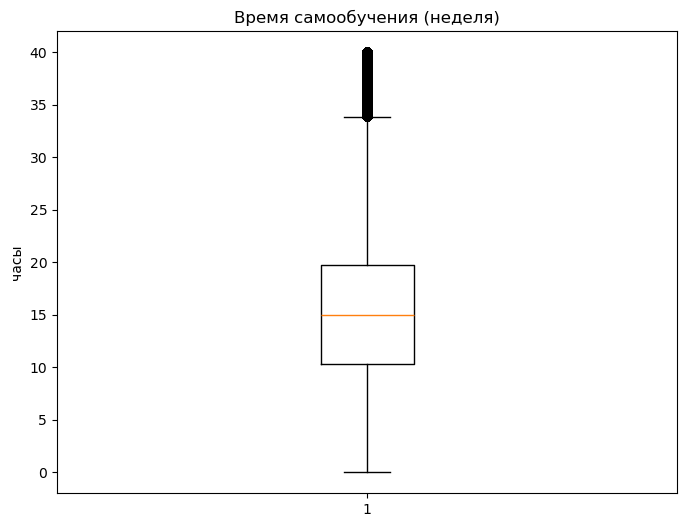

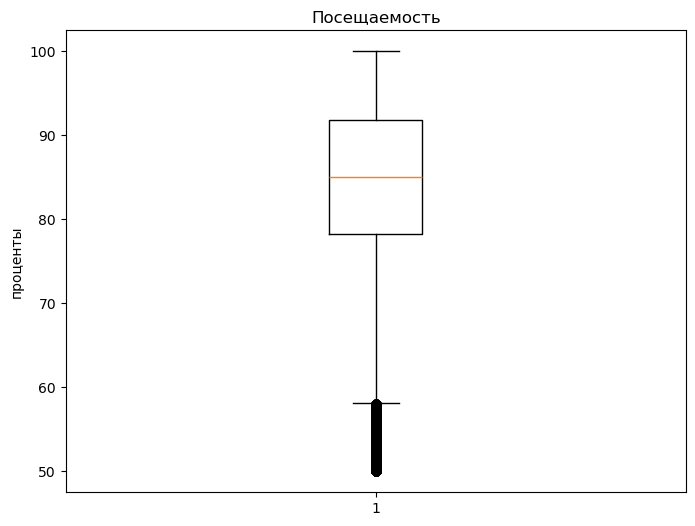

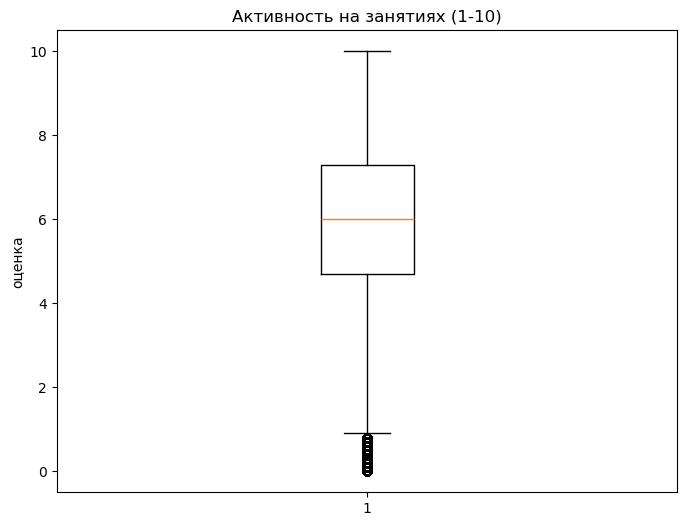

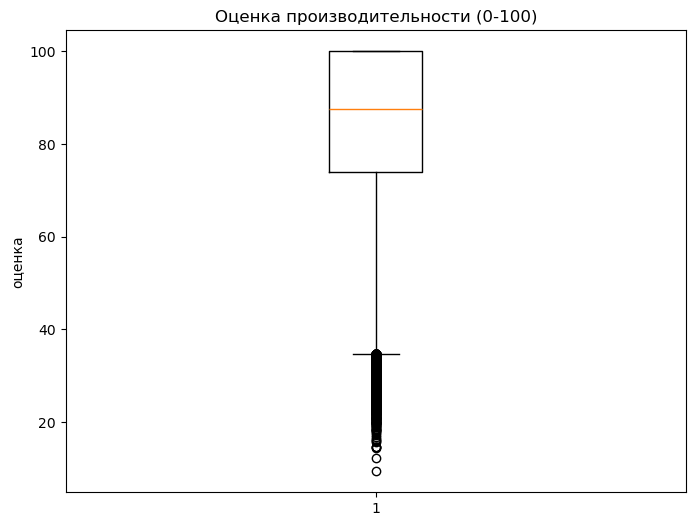

In [3]:
def make_exhaust_barplots():
    plt.figure(figsize=(8, 6))
    plt.boxplot(dataset['weekly_self_study_hours'], showfliers=True)
    plt.title('Время самообучения (неделя)')
    plt.ylabel('часы')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.boxplot(dataset['attendance_percentage'], showfliers=True)
    plt.title('Посещаемость')
    plt.ylabel('проценты')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.boxplot(dataset['class_participation'], showfliers=True)
    plt.title('Активность на занятиях (1-10)')
    plt.ylabel('оценка')
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.boxplot(dataset['total_score'], showfliers=True)
    plt.title('Оценка производительности (0-100)')
    plt.ylabel('оценка')
    plt.show()
    
make_exhaust_barplots()

In [4]:
def exhaust_process():
    before_count = dataset.size

    Q1 = dataset['weekly_self_study_hours'].quantile(0.25)
    Q3 = dataset['weekly_self_study_hours'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = dataset[
        (dataset['weekly_self_study_hours'] >= lower_bound) & (dataset['weekly_self_study_hours'] <= upper_bound)]
    
    Q1 = df_filtered['attendance_percentage'].quantile(0.25)
    Q3 = df_filtered['attendance_percentage'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df_filtered[
        (df_filtered['attendance_percentage'] >= lower_bound) & (df_filtered['attendance_percentage'] <= upper_bound)]
    
    Q1 = df_filtered['class_participation'].quantile(0.25)
    Q3 = df_filtered['class_participation'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df_filtered[
        (df_filtered['class_participation'] >= lower_bound) & (df_filtered['class_participation'] <= upper_bound)]
    
    Q1 = df_filtered['total_score'].quantile(0.25)
    Q3 = df_filtered['total_score'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df_filtered[
        (df_filtered['total_score'] >= lower_bound) & (df_filtered['total_score'] <= upper_bound)]
    
    
    print(f'Удалено {before_count - df_filtered.size}')
    return df_filtered

dataset = exhaust_process()

Удалено 82950


### Обработка типов данных

In [5]:
def map_column(df, col, in_place=True, handle_case=True):
    mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
    
    if not in_place:
        df = df.copy()

    if handle_case:
        tmp = df[col].astype(str).str.strip().str.upper()
    else:
        tmp = df[col]

    mapped = tmp.map(mapping)
    

    df[col] = mapped
    return df

def change_columns_type():
    dataset['weekly_self_study_hours'] = dataset['weekly_self_study_hours'].astype('int')
    dataset['attendance_percentage'] = dataset['attendance_percentage'].astype('int')
    dataset['total_score'] = dataset['total_score'].astype('int')
    dataset['class_participation'] = dataset['class_participation'].astype('int')
    
    map_column(dataset, "grade")

### Разделение набора данных на обучающий и тестовый


In [6]:
X = dataset.drop(columns=['total_score', 'student_id', 'grade'], errors='ignore')
y = dataset['total_score']

stratify_arg = y if (y.dtype == 'O' or y.dtype.name == 'category' or y.nunique() <= 20) else None


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=stratify_arg
)

print(f"Train: {len(X_train)} rows, Test: {len(X_test)} rows")

Train: 788940 rows, Test: 197235 rows


## 3. Построение и обучение моделей

In [7]:
models = {
    'Linear': Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=1.0))]),
    'Lasso': Pipeline([('lasso', Lasso(alpha=0.1, max_iter=10000))]),
    'Poly2+Ridge': Pipeline([('scaler', StandardScaler()),
                             ('poly', PolynomialFeatures(degree=2, include_bias=False)),
                             ('ridge', Ridge(alpha=1.0))])
}

for name, model in models.items():
    model.fit(X_train, y_train)

## 4.Оценка результатов моделей

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_regression_model(model):

    y_pred = model.predict(X_test)


    mse  = mean_squared_error(y_test, y_pred) 
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred) 

    return {'y_pred': y_pred, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

def compare_models(models, sort_by='rmse', ascending=True, save_path=None):
    
    rows = []

    if isinstance(models, dict):
        iterator = models.items()
    else:
        iterator = models

    for name, model in iterator:
        try:
            res = evaluate_regression_model(model)
        except Exception as e:

            print(f"Error evaluating model {name}: {e}")
            rows.append({'model': name, 'mse': np.nan, 'rmse': np.nan, 'mae': np.nan, 'r2': np.nan})
            continue

        rows.append({'model': name,
                     'mse':  res['mse'],
                     'rmse': res['rmse'],
                     'mae':  res['mae'],
                     'r2':   res['r2']})

    df = pd.DataFrame(rows).set_index('model')

    if sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=ascending)

    df_display = df.copy()
    df_display = df_display.round(4)

    if save_path is not None:
        df.to_csv(save_path)
        print(f"Saved comparison to {save_path}")

    print("\nModel comparison (sorted by {}):".format(sort_by))
    print(df_display)

    return df

compare_models(models)


Model comparison (sorted by rmse):
                 mse    rmse     mae      r2
model                                       
Poly2+Ridge  68.1120  8.2530  6.3240  0.7088
Linear       78.2960  8.8485  7.0824  0.6653
Ridge        78.2960  8.8485  7.0824  0.6653
Lasso        78.2962  8.8485  7.0824  0.6653


,mse,rmse,mae,r2
model,,,,
Poly2+Ridge,68.112000,8.252999,6.323962,0.708823
Linear,78.295967,8.848501,7.082425,0.665287
Ridge,78.295968,8.848501,7.082425,0.665287
Lasso,78.296177,8.848513,7.082354,0.665286


## 5. Выбор лучшей модели и анализ результатов
Лучше всего себя показала модель Poly2+Ridge RMSE = 8.253, MAE = 6.324, R² = 0.7088, MSE = 68.112. 
Самыми ценными мы считаем RMSE/MSE, поскольку именно большие ошибки критичны.